<a href="https://colab.research.google.com/github/huimarco/spotify-rating-prediction/blob/main/spotify_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview

Spotify one of the largest music streaming service providers, with over 422 million monthly active users, including 182 million paying subscribers, as of March 2022. Many share their experience with the application in the form of a written review and a rating score on its Google Play Store page.


---


This project looks to use user written reviews to predict given app rating score.


---


Through this project, I hope to practice/gain exposure to:
* basic natural language processing techniques
* basic sentiment analysis
* data wrangling in python
* machine learning models in python (random forest, XGBoost, etc.)
* clear written documentation

## Preparation

We begin by loading in then reading the data onto the virtual machine.

Install libraries to virtual machine

In [1]:
pip install emoji --upgrade
pip install autocorrect
pip install --user -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=ece2e3cd55bfd3e49d30c388825b6eaeb75e5ec978a66fd10de6d145a9b96aad
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


Import libaries to the notebook

In [3]:
# wrangle data
import numpy as np
import pandas as pd

# import files
from google.colab import files
import io

# visualise data
import seaborn as sns

Upload csv files from local desktop

In [4]:
uploaded = files.upload()

Saving reviews.csv to reviews.csv


Read csv files into pandas dataframes

In [6]:
data = pd.read_csv(io.StringIO(uploaded['reviews.csv'].decode('utf-8')))

## Exploratory Data Analysis

We perform some basic EDA in order to better understand the data we are working with.

Get a general overview of data, including the name, number of non-null values, and data type of each column

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


See summary statistics of numerical columns

In [8]:
data.describe()

,Rating,Total_thumbsup
count,61594.000000,61594.000000
mean,3.155989,7.649381
std,1.673285,89.323143
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8195.000000


Visualise distribution of ratings

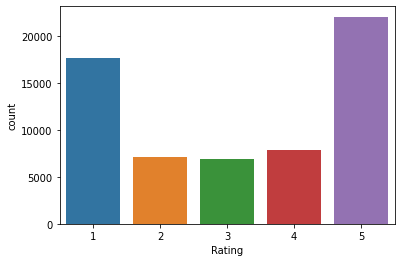

In [9]:
sns.countplot(x='Rating',data=data)

## Reload Data

In [98]:
data = pd.read_csv(io.StringIO(uploaded['reviews.csv'].decode('utf-8')))

## Data Wrangling

We transform raw data into a more readily usable format.

Import packages

In [99]:
import emoji
from autocorrect import Speller
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

Drop unecessary columns

In [100]:
data.drop(['Time_submitted','Total_thumbsup','Reply'],axis=1,inplace=True)

Remove numbers from `Reviews`

In [101]:
data['textReview'] = data['Review'].str.replace('\d','',regex=True)

Create new column `textReview` with emojis removed

In [102]:
data['textReview'] = data['Review'].apply(lambda x : emoji.replace_emoji(x, replace=''))

Normalise text from `textReview` (accents, fonts, etc.)

In [103]:
import unicodedata

def simplify(text):
	try:
		text = unicode(text, 'utf-8')
	except NameError:
		pass
	text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
	return str(text)

In [104]:
data['textReview'] = data['textReview'].apply(lambda x : simplify(x))

Remove rows where `textReview` were simplified to empty strings

In [105]:
# empty column true if the length of review is zero after stripped of all whitespace
data['empty'] = data['textReview'].str.replace(' ', '').str.len() == 0

# drop rows where empty column is true
data.drop(data[data['empty']].index, axis=0,inplace=True)

# drop empty column
data.drop(['empty'],axis=1,inplace=True)

Remove punctuation from `textReview`

In [106]:
data['textReview'] = data['textReview'].str.replace('[^\w\s]','',regex=True)

Correct spelling in `textReview`

In [ ]:
spell = Speller(lang='en')
data['textReview'] = data['textReview'].apply(lambda x : spell(x))

Function to stem and remove stopwords from `textReview`

In [96]:
def preProcess(x):

  # text
  output = x

  # tokenize
  output = nltk.word_tokenize(output)

  # stem words
  port = PorterStemmer()
  output = [port.stem(i) for i in output]

  # remove stopwords
  stopWords = set(stopwords.words('english'))
  output = [i for i in output if not i.lower() in stopWords]

  # detokenize
  treebank = TreebankWordDetokenizer()
  output = treebank.detokenize(output)

  return output

In [ ]:
data['textReview'] = data['textReview'].apply(lambda x : preProcess(x))

## Feature Engineering

With written reviews cleaned and converted to TextBlobs, we can now create some new variables that aren't in the training set to be used for modelling.
* wordCount (int): the number of words in a review
* sentenceCount (int): the number of sentences in a review
* polarity (float): overall sentiment of a review where -1.0 is most negative and 1.0 is most positive
* subjectivity (float): overall subjectivity of a review where 0.0 is very objective and 1.0 is very subjective
* mentionAds (boolean): whether 'ad' or related words is mentioned in the review

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

Create `polarity`

In [ ]:
sia = SentimentIntensityAnalyzer()
data['polarity'] = data['textReview'].apply(lambda x : sia.polarity_scores(x))

## Experiment

In [24]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Create `wordCount`

In [25]:
data['wordCount'] = data['textReview'].apply(lambda x : len(TextBlob(x).words))

Create `sentenceCount`

In [ ]:
data['wordCount'] = data['textReview'].apply(lambda x : len(TextBlob(x).sentences))

In [26]:
data['polarity'] = data['textReview'].apply(lambda x : TextBlob(x).sentiment.polarity)

Create `subjectivity`

In [27]:
data['subjectivity'] = data['textReview'].apply(lambda x : TextBlob(x).sentiment.subjectivity)

Create `mentionAds`

In [28]:
import re

def mentionAds(x):
  regexp = re.compile(r'\sad+s*\s | advert')
  if regexp.search(x):
    return(True)
  else:
    return(False)

data['mentionAds'] = data['textReview'].apply(lambda x : mentionAds(x))

In [30]:
data.head(10)

,Review,Rating,textReview,wordCount,polarity,subjectivity,mentionAds
0,"Great music service, the audio is high quality...",5,"Great music service, the audio is high quality...",21,0.440333,0.654667,False
1,Please ignore previous negative rating. This a...,5,Please ignore previous negative rating. This a...,15,0.166667,0.495833,False
2,"This pop-up ""Get the best Spotify experience o...",4,"This pop-up ""Get the best Spotify experience o...",20,0.100000,0.600000,False
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently,9,-0.266667,0.483333,False
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didn't ...,22,0.000000,0.000000,False
5,The player controls sometimes disappear for no...,3,The player controls sometimes disappear for no...,19,0.000000,0.000000,False
6,I love the selection and the lyrics are provid...,5,I love the selection and the lyrics are provid...,16,0.625000,0.600000,False
7,Still extremely slow when changing storage to ...,3,Still extremely slow when changing storage to ...,65,-0.150000,0.250000,False
8,It's a great app and the best mp3 music app I ...,5,It's a great app and the best mp3 music app I ...,46,0.950000,0.587500,False
9,"I'm deleting this app, for the following reaso...",1,"I'm deleting this app, for the following reaso...",86,0.178571,0.426786,False


In [18]:
data.head(50)

,Review,Rating,textReview
0,"Great music service, the audio is high quality...",5,"Great music service, the audio is high quality..."
1,Please ignore previous negative rating. This a...,5,Please ignore previous negative rating. This a...
2,"This pop-up ""Get the best Spotify experience o...",4,"This pop-up ""Get the best Spotify experience o..."
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didn't ...
5,The player controls sometimes disappear for no...,3,The player controls sometimes disappear for no...
6,I love the selection and the lyrics are provid...,5,I love the selection and the lyrics are provid...
7,Still extremely slow when changing storage to ...,3,Still extremely slow when changing storage to ...
8,It's a great app and the best mp3 music app I ...,5,It's a great app and the best mp3 music app I ...
9,"I'm deleting this app, for the following reaso...",1,"I'm deleting this app, for the following reaso..."


In [ ]:
data['wordCount'] = data['stripped'].str.count(' ') + 1

In [ ]:
data[5694:5698]

,Review,Rating,wordCount
5694,,5,21
5695,its work great i highly recommend spotify addi...,2,24
5696,it is really best app for music,5,9
5697,adds in a row and premium is really expensive,3,10


In [ ]:
from textblob import TextBlob

In [ ]:
data['Review'] = data['Review'].apply(lambda x : TextBlob(x))

In [ ]:
data['wordCount'] = data['Review'].str.count(' ') + 1

In [ ]:
data[5694:5698]

,Review,Rating,wordCount
5694,"( , , , , , , , , , , , , , , , ...",5,NaN
5695,"(i, t, s, , w, o, r, k, , g, r, e, a, t, , ...",2,NaN
5696,"(i, t, , i, s, , r, e, a, l, l, y, , b, e, ...",5,NaN
5697,"( , a, d, d, s, , i, n, , a, , r, o, w, , ...",3,NaN


In [ ]:
data[5694:5697]

,Review,Rating,emojiCount,english,wordCount
5694,,5,0,False,21
5695,its work great i highly recommend spotify addi...,2,0,True,24
5696,it is really best app for music,5,2,True,9


In [ ]:
len(data[5694:5695]['Review'])

1

In [ ]:
data[data['english']==False]

,Review,Rating,emojiCount,english
1077,its a good app its assessable and easy to use ...,5,1,False
1293,really good to use ive been using spotify a lo...,5,0,False
1743,sometimes its laggy for me crashes often too,5,0,False
2680,good app but now song lyrics wrong having படல ...,3,0,False
3305,man spotifys the great to know that it has pu...,5,1,False
...,...,...,...,...
59616,have been able to download all the old songs f...,5,0,False
59956,ui could be more organized intuitive otherwis...,4,0,False
60139,i am using the versión premium in south korea ...,1,1,False
60571,opinión good opinión this is the best app in w...,5,1,False


In [ ]:
data.drop('english', inplace=True)

,Review,Rating,emojiCount,wordCount,english
0,great music service the audio is high quality ...,5,0,21,True
1,please ignore previous negative rating this ap...,5,0,15,True
2,this popup get the best spotify experience on ...,4,0,19,True
3,really buggy and terrible to use as of recently,1,0,9,True
4,dear spotify why do i get songs that i didnt p...,1,0,21,True


## Feature Engineering

Features used for modelling

| name | description |
| --- | --- |
|emojiCount|number of emojis used in review|
|wordCount|number of words used in review|
|adj|number of adjectives used in review|





Create emojiCount

In [ ]:
data['emojiCount'] = data['Review'].apply(lambda x : emoji.emoji_count(x))
# remove emojis from review once counted
data['Review'] = data['Review'].apply(lambda x : emoji.replace_emoji(x, replace=''))

Create wordCount

In [ ]:
data['wordCount'] = data['Review'].str.count(' ') + 1

Create parts of speech

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer = TfidfVectorizer(use_idf=True,
                                   tokenizer = LemmaTokenizer(),
                                   strip_accents = 'unicode', 
                                   stop_words = 'english') 
# just send in all your docs here 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(data['Review'])

# get the first vector out (for the first document) 
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 

# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), 
                  index = tfidf_vectorizer.get_feature_names(),
                  columns = ["tfidf"]) 

df.sort_values(by = ["tfidf"], ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
quick,0.434169
friendly,0.379796
high,0.375112
support,0.328215
audio,0.318058
...,...
frisbee,0.000000
fringe,0.000000
frim,0.000000
frill,0.000000


In [ ]:
data.head()

,Review,Rating,emojiCount,wordCount
0,great music service the audio is high quality ...,5,0,21
1,please ignore previous negative rating this ap...,5,0,15
2,this popup get the best spotify experience on ...,4,0,19
3,really buggy and terrible to use as of recently,1,0,9
4,dear spotify why do i get songs that i didnt p...,1,0,21


In [ ]:
#instantiate CountVectorizer() 
cv = CountVectorizer(tokenizer = LemmaTokenizer(),
                     strip_accents = 'unicode', 
                     stop_words = 'english') 
# this steps generates word counts for the words in each review 
word_count_vector = cv.fit_transform(data['Review'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# check that there are 61594 reviews and 28493 unique words
word_count_vector.shape

(61594, 26121)

In [ ]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

NameError: ignored

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
data_vector = tfidf.fit_transform(data)

In [ ]:
data_vector

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

OTHER

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
x_vector = tfidf.fit_transform(x)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
review = 'this is Mony app no install this app, wink is best and gana is best app'
review = review.lower()

# tokenize words
tokens = nltk.word_tokenize(review)

# assign parts of speech (pos) to each word
tagged = nltk.pos_tag(tokens)

In [ ]:
tagged

[('this', 'DT'),
 ('is', 'VBZ'),
 ('mony', 'JJ'),
 ('app', 'IN'),
 ('no', 'DT'),
 ('install', 'NN'),
 ('this', 'DT'),
 ('app', 'NN'),
 (',', ','),
 ('wink', 'NN'),
 ('is', 'VBZ'),
 ('best', 'RBS'),
 ('and', 'CC'),
 ('gana', 'NN'),
 ('is', 'VBZ'),
 ('best', 'RBS'),
 ('app', 'NN')]

In [ ]:
# data['cleanReview'] = data['Review'].apply(lambda x : emoji.demojize(x, delimiters=(' :', ': ')) )